In [20]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [21]:
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras_core as keras
from models.analytical.trapdiffusion import SingleOccupationSingleIsotope
from models.analytical.datasets import create_dataset, load_dataset
import matplotlib.pyplot as plt

In [22]:
create_dataset(SingleOccupationSingleIsotope, 'Single-Occupation, Single Isotope, fixed matrix',configs= 1, initial_per_config=10000,n_timesteps=100,include_params=False, seed = 1)

Estimated size: 53.40576171875 MB


initial_values:   0%|          | 0/10000 [00:00<?, ?it/s]

In [85]:
create_dataset(SingleOccupationSingleIsotope,"Single-Occupation, Single Isotope, random matrix",configs=1000,initial_per_config=100,n_timesteps=50, include_params=True, seed = 1)

Estimated size: 648.49853515625 MB


configs:   0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
x_basic,y_basic, info_basic = load_dataset('Single-Occupation, Single Isotope, fixed matrix')

In [69]:
np.random.seed(1)
s = SingleOccupationSingleIsotope()
correction = torch.tensor(s.correction_factors()).to('cuda')
def physics_loss(y_true, y_pred, physics_weight = 0):
    return torch.mean(torch.abs(y_true-y_pred), axis=0) +physics_weight* torch.abs(1-y_pred * correction)

In [70]:
# Model parameters
input_shape = (info_basic["input_dim"], )

basic_model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(3,activation="relu")
    ],
    name = "Single-Occupation, Single Isotope, fixed matrix"
)
basic_model.compile(
    loss=physics_loss,
    optimizer=keras.optimizers.Adam(learning_rate=3e-3),
)
basic_model.summary()


Model: "Single-Occupation, Single Isotope, fixed matrix"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)               │        640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_46 (Dense)                │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_47 (Dense)                │ (None, 3)                 │        195 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 9,091 (35.51 KB)

 Trainable params: 9,091 (35.51 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
basic_model.fit(
    x_basic,
    y_basic,
    batch_size=2**12,
    epochs=10,
    shuffle=True,
    validation_split=0.15,
)


Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1469 - val_loss: 0.0876
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0808 - val_loss: 0.0791
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0792 - val_loss: 0.0798
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0814 - val_loss: 0.0783
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0784 - val_loss: 0.0772
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0780 - val_loss: 0.0776
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0778 - val_loss: 0.0768
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0777 - val_loss: 0.0772
Epoch 9/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0775 - val_loss: 0.0762
Epoch 10/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0773 - val_loss: 0.0803


In [61]:
basic_model.save("trained_models/SOSI_fixed.keras")

In [20]:
basic_model = keras.models.load_model('trained_models/SOSI_fixed.keras')

For evaluation, `n_eval` is different to the one initially used for training to esure smoothness of the models output, as the model is now evaluated at unseen timesteps.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


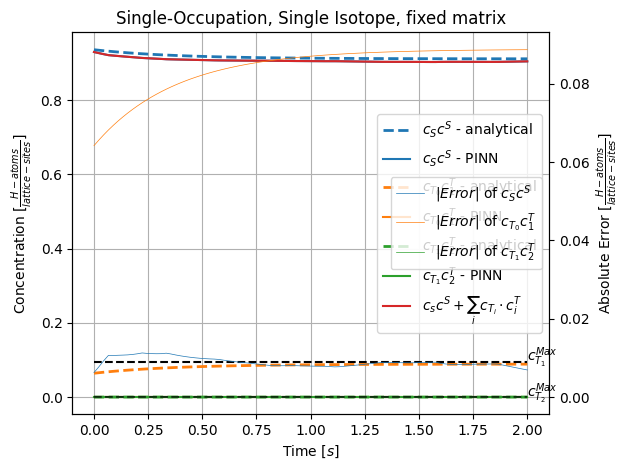

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


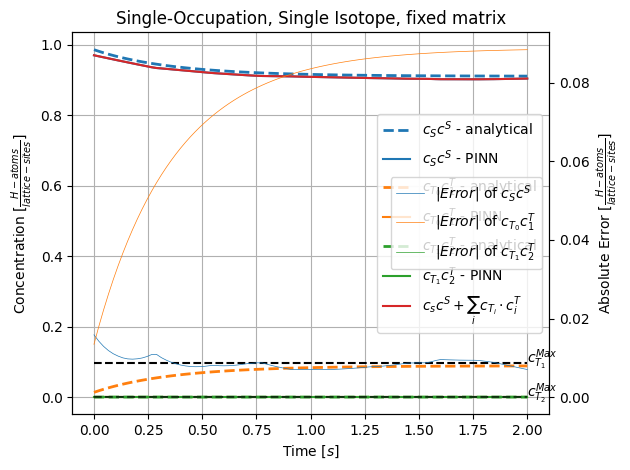

In [72]:
np.random.seed(1)
analytical_model = SingleOccupationSingleIsotope()
analytical_model.evaluate(basic_model, n_eval = 91)
plt.show()
analytical_model.evaluate(basic_model, n_eval = 91)
plt.show()

In [86]:
x_full,y_full, info_full = load_dataset('Single-Occupation, Single Isotope, random matrix')

In [154]:
# Model parameters
input_shape = (info_full["input_dim"], )

full_model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(3,activation="linear")
    ],
    name = "Single-Occupation, Single Isotope, random matrix"
)
full_model.compile(
    loss=keras.losses.MeanAbsoluteError(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-3),
)
full_model.summary()

Model: "Single-Occupation, Single Isotope, random matrix"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 512)               │      7,680 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_82 (Dense)                │ (None, 64)                │     32,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_83 (Dense)                │ (None, 3)                 │        195 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 40,707 (159.01 KB)

 Trainable params: 40,707 (159.01 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
full_model.fit(
    x_full,
    y_full,
    batch_size=2**12,
    epochs=20,
    validation_split=0.15,
)

Epoch 1/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.3507 - val_loss: 0.1023
Epoch 2/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1700 - val_loss: 0.0895
Epoch 3/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1605 - val_loss: 0.0814
Epoch 4/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1482 - val_loss: 0.0713
Epoch 5/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1456 - val_loss: 0.0629
Epoch 6/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1416 - val_loss: 0.0908
Epoch 7/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1387 - val_loss: 0.0860
Epoch 8/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.1318 - val_loss: 0.0889
Epoch 9/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.1330 - val_loss: 0.0827
Epoch 10/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1299 - val_loss: 0.0702
Epoch 11/20
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1285 - val_loss: 0.0758
Epoch 12

KeyboardInterrupt: 

In [161]:
full_model.save('trained_models/SOSI_random.keras')

In [166]:
full_model = keras.models.load_model('trained_models/SOSI_random.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


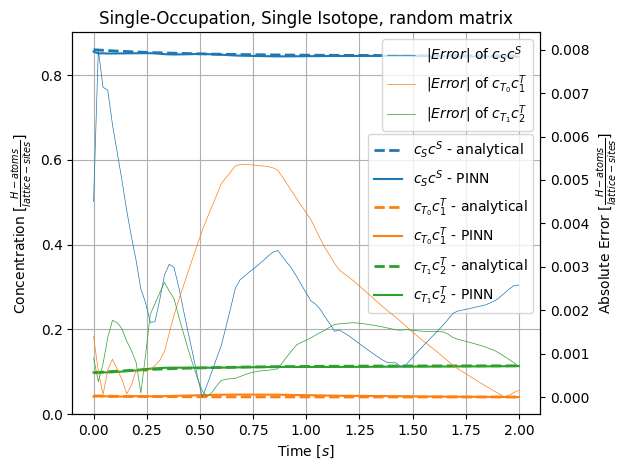

In [173]:
s = SingleOccupationSingleIsotope()
s.evaluate(full_model, include_params=True, n_eval = 91)